In [1]:
import numpy as np
import torch.nn as nn
from dataset import CityscapesDataset
from torchvision.datasets import Cityscapes
import torch.nn.functional as F
from GenISP import *
from unet import *
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os 
from tqdm import trange

In [2]:
# ALL CREDITS TO https://github.com/goldbattle/pytorch_unet/blob/master/script_train.py FOR DATASET CLASS!
# path = "/Users/charlesdowns/Desktop/cityscapes_mini/" # Mini dataset on Macbook
path = "/home/charles/Desktop/cityscapes"
img_data = CityscapesDataset(path, split='train', mode='fine')
batch_size = 8
img_batch = torch.utils.data.DataLoader(img_data, batch_size=batch_size, shuffle=True, num_workers=16)

In [3]:
# Hyperparameters and stuff
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

# Set model parameters
epochs = 10
learning_rate = 0.0001
in_c = 3

# Create the model
in_channels = 3 # Raw RGB image
hidden_channels = [16, 32, 128, 16, 64, 3]
out_features = 3 # GenISP output channels
PreNet = GenISPV2( in_channels, hidden_channels, out_features)
UNet = UNet(in_c, img_data.num_classes, 64)
# Net = nn.Sequential(PreNet,UNet)
PreNet.to(device)
UNet.to(device)
train_loss = []

# Since our goal here is to segment, we will use the cross entropy loss function and 4 classes (background, road, sky, car)
criterion = nn.CrossEntropyLoss() # for segment loss. could also be reconstruction loss, then it is N1 loss 
num_classes = img_data.num_classes
print(num_classes)
optimizer = torch.optim.Adam(UNet.parameters(), lr=learning_rate)

cuda:0
4


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Batch: 1/372, Loss: 1.4606


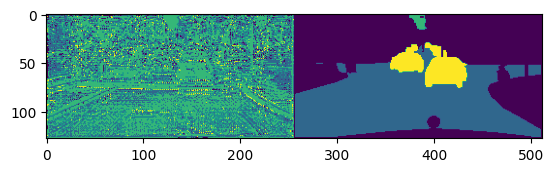

Epochs:  10%|█         | 1/10 [01:41<15:16, 101.83s/it]

Epoch: 2/10, Batch: 1/372, Loss: 0.2933


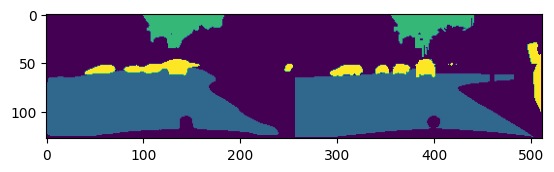

Epochs:  20%|██        | 2/10 [03:20<13:19, 99.94s/it] 

Epoch: 3/10, Batch: 1/372, Loss: 0.2254


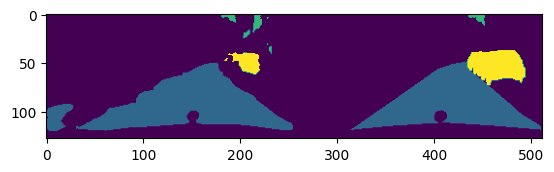

Epochs:  30%|███       | 3/10 [05:41<13:51, 118.80s/it]

Epoch: 4/10, Batch: 1/372, Loss: 0.1641


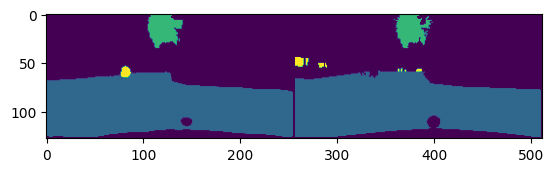

Epochs:  40%|████      | 4/10 [08:09<13:02, 130.42s/it]

Epoch: 5/10, Batch: 1/372, Loss: 0.2660


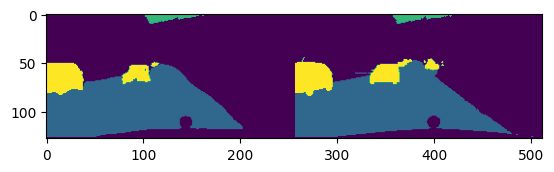

Epochs:  50%|█████     | 5/10 [09:55<10:06, 121.35s/it]

Epoch: 6/10, Batch: 1/372, Loss: 0.1838


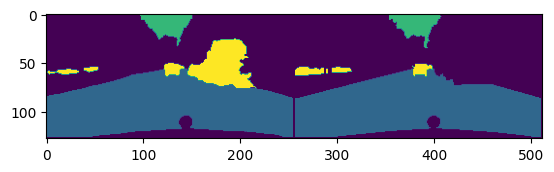

Epochs:  60%|██████    | 6/10 [11:32<07:32, 113.13s/it]

Epoch: 7/10, Batch: 1/372, Loss: 0.0907


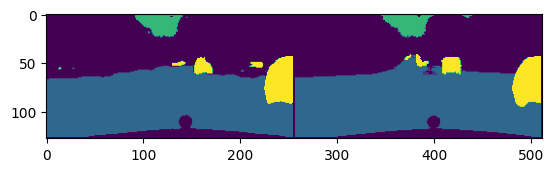

Epochs:  70%|███████   | 7/10 [13:10<05:24, 108.25s/it]

Epoch: 8/10, Batch: 1/372, Loss: 0.0821


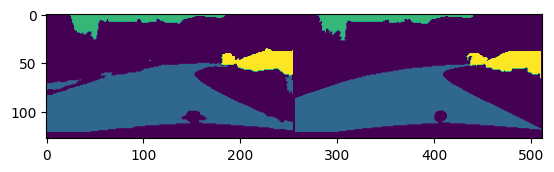

Epochs:  80%|████████  | 8/10 [14:47<03:29, 104.73s/it]

Epoch: 9/10, Batch: 1/372, Loss: 0.1163


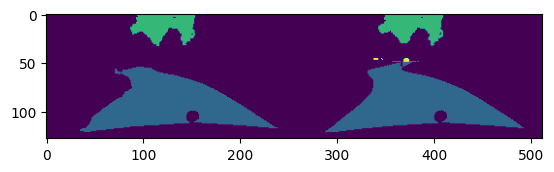

Epochs:  90%|█████████ | 9/10 [16:27<01:43, 103.02s/it]

Epoch: 10/10, Batch: 1/372, Loss: 0.0973


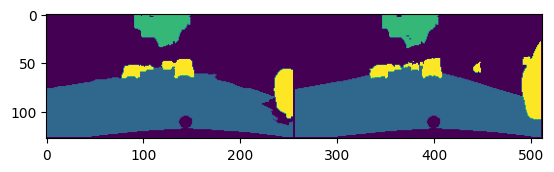

Epochs: 100%|██████████| 10/10 [18:06<00:00, 108.68s/it]


In [4]:
t = trange(epochs, desc="Epochs", leave=True)
for epoch in t:
    # TODO: use tqdm for progress bar
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(img_batch):
        imagergb = imagergb.to(device)
        labelmask = labelmask.to(device)
        labelrgb = labelrgb.to(device)
        # print(imagergb.shape)
        optimizer.zero_grad()
        # output1 = PreNet(imagergb)
        # output2 = F.pad(input=output1, pad=(2, 2, 2, 2))
        output = UNet(imagergb)
        loss = criterion(output, labelmask)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        if idx_batch % 1000 == 0:
            print("Epoch: {}/{}, Batch: {}/{}, Loss: {:.4f}".format(epoch+1, epochs, idx_batch+1, len(img_batch), loss.item()))
            # Display the output and ground truth next to eachother 
            output = output.detach().cpu().numpy()
            output = np.argmax(output, axis=1)
            output_batch = output.shape[0]
            output = output.reshape((output_batch, output.shape[1], output.shape[2]))
            # output = output.reshape((output.shape[1], output.shape[2]))

            labelmask = labelmask.detach().cpu().numpy()
            labelmast_batch = labelmask.shape[0]
            labelmask = labelmask.reshape((labelmast_batch, labelmask.shape[1], labelmask.shape[2]))
           
            # concat output and labelmask
            output = np.concatenate((output, labelmask), axis=2)
            plt.imshow(output[1])
            plt.show()

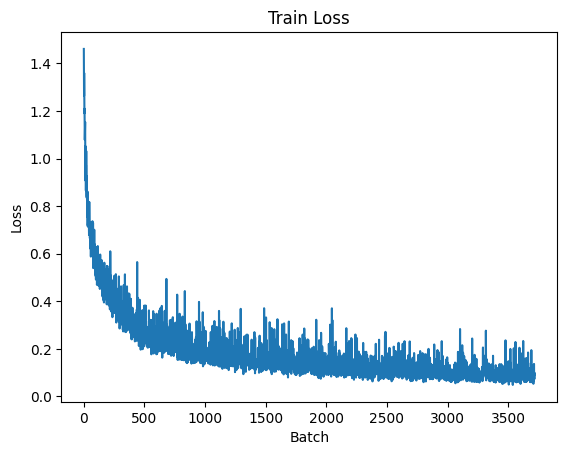

Saved PyTorch Model State to model.pth


In [5]:
# Plot the training loss
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

# Save the model
torch.save(UNet.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [6]:
for param in UNet.parameters():
    print(param.data)

tensor([[[[-3.2911e-02,  5.5661e-02,  1.5925e-01],
          [ 5.9606e-02,  5.7058e-02,  1.9558e-01],
          [ 1.7801e-01,  1.9344e-01, -7.6962e-02]],

         [[-5.1173e-02, -1.8805e-01,  6.2155e-03],
          [ 2.1786e-02, -4.7128e-02, -6.2792e-02],
          [ 6.1781e-02, -7.8527e-02, -9.3497e-02]],

         [[-3.6698e-02, -5.9007e-02,  1.8325e-02],
          [-1.8867e-01, -1.8022e-01, -1.5734e-01],
          [-1.2424e-01, -1.1237e-01,  1.8539e-02]]],


        [[[-5.8638e-02,  6.5632e-02, -1.8265e-01],
          [ 2.5153e-04,  1.0220e-01,  8.8898e-02],
          [-1.9904e-01,  1.6459e-01,  1.4528e-01]],

         [[ 1.2231e-01,  1.1277e-01, -1.1938e-01],
          [ 1.5278e-01,  1.4920e-01,  1.8764e-01],
          [ 8.9146e-02,  4.1713e-02, -1.2847e-01]],

         [[ 3.6693e-02, -1.0512e-01,  1.1861e-01],
          [-1.8012e-01,  3.9231e-03,  2.5720e-02],
          [ 8.5452e-02, -5.3216e-02,  1.6635e-02]]],


        [[[ 1.6433e-01, -3.0227e-02, -1.6963e-01],
          [ 7.4